# Rapid, systematic updating of movement by accumulated decision evidence


Manuel Molano-Mazón (1,2,3,5) , Alexandre Garcia-Duran (2,3) , Jordi Pastor-Ciurana (1,3), Lluís Hernández-Navarro (1), Lejla Bektic (1), Debora Lombardo (1), Jaime de la Rocha (1,4,5),  Alexandre Hyafil (2,4, 5)


1. IDIBAPS, Rosselló 149, Barcelona, 08036, Spain 
2. Centre de Recerca Matemàtica (CRM), Bellaterra, Spain
3. These authors contributed equally
4. These authors contributed equally 
5. Corresponding author


This is a Notebook to show the optimization/fitting pipeline.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import time
import sys
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sbi.inference import MNLE
from sbi.utils import MultipleIndependent
import torch
from torch.distributions import Beta, Binomial, Gamma, Uniform
from sbi.analysis import pairplot
import matplotlib.pylab as pl
import arviz as az
import time
from pybads import BADS
import warnings
warnings.filterwarnings('ignore')

# sys.path.append("C:/Users/Alexandre/Documents/GitHub/")  # Alex
sys.path.append("C:/Users/agarcia/Documents/GitHub/custom_utils")  # Alex CRM
sys.path.append('C:/Users/alexg/Onedrive/Documentos/GitHub/custom_utils')  # Alex
# sys.path.append("/home/garciaduran/custom_utils")  # Cluster Alex
# sys.path.append("/home/jordi/Repos/custom_utils/")  # Jordi

from utilsJ.Models.extended_ddm_v2 import trial_ev_vectorized,\
    data_augmentation, get_data_and_matrix
from utilsJ.Behavior.plotting import binned_curve
import utilsJ.Models.dirichletMultinomialEstimation as dme
from utilsJ.Models.optimization import simulation, prepare_fb_data

In [2]:
# DATA_FOLDER = 'C:/Users/Alexandre/Desktop/CRM/Alex/paper/data/'  # Alex
# DATA_FOLDER = '/home/garciaduran/data/'  # Cluster Alex
# DATA_FOLDER = '/home/jordi/DATA/Documents/changes_of_mind/data_clean/'  # Jordi
# DATA_FOLDER = 'C:/Users/agarcia/Desktop/CRM/Alex/paper/data/'  # Alex CRM
DATA_FOLDER = 'C:/Users/alexg/Onedrive/Escritorio/CRM/data/'  # Alex

# SV_FOLDER = 'C:/Users/Alexandre/Desktop/CRM/Results_LE43/'  # Alex
# SV_FOLDER = '/home/garciaduran/opt_results/'  # Cluster Alex
# SV_FOLDER = '/home/jordi/DATA/Documents/changes_of_mind/opt_results/'  # Jordi
# SV_FOLDER = 'C:/Users/agarcia/Desktop/CRM/Alex/paper/'  # Alex CRM
SV_FOLDER = 'C:/Users/alexg/Onedrive/Escritorio/CRM/'  # Alex

In [3]:
BINS = np.arange(1, 320, 20)
CTE = 1/2 * 1/600 * 1/995  # contaminants
CTE_FB = 1/600

First, we load the data from a certain rat or human. In this case we will use a rat, ``LE43``. We extract the important vairables, movement and reaction times (MT, RT), choice, stimulus, prior and trial index.

In [4]:
pright = None
num_times_tr = 1
num_trials_training = int(1e4)
index = np.arange(num_trials_training)
# load real data
subject = 'LE43'
df = get_data_and_matrix(dfpath=DATA_FOLDER + subject, return_df=True,
                         sv_folder=SV_FOLDER, after_correct=True,
                         silent=True, all_trials=True,
                         srfail=True)
mt = df.resp_len.values
choice = df.R_response.values
zt = np.nansum(df[["dW_lat", "dW_trans"]].values, axis=1)
stim = np.array([stim for stim in df.res_sound])
coh = np.array(df.coh2)
trial_index = np.array(df.origidx)
com = np.array(df.CoM_sugg)
gt = np.array(df.rewside) * 2 - 1
print('Ended loading data')


Loading data
Ended loading data


Now, we build prior distributions. For simplicity, we defined uniform distributions for all parameters. Note that the broader the grid is, the harder will be to approximate the likelihood.

In [5]:
# 1. Parameters' prior distro definition
prior = MultipleIndependent([Uniform(torch.tensor([1e-1]),
                                     torch.tensor([1])),  # prior weight
                             Uniform(torch.tensor([1e-3]),
                                     torch.tensor([0.8])),  # stim weight
                             Uniform(torch.tensor([1e-2]),
                                     torch.tensor([3.])),  # evidence integrator bound
                             Uniform(torch.tensor([1e-8]),
                                     torch.tensor([1.])),  # CoM bound
                             Uniform(torch.tensor([4.]),
                                     torch.tensor([12.])),  # afferent time
                             Uniform(torch.tensor([4.]),
                                     torch.tensor([12.])),  # efferent time
                             Uniform(torch.tensor([9.]),
                                     torch.tensor([16.])),  # time offset action
                             Uniform(torch.tensor([1e-2]),
                                     torch.tensor([0.08])),  # intercept trial index for action drift
                             Uniform(torch.tensor([1e-7]),
                                     torch.tensor([5e-5])),  # slope trial index for action drift
                             Uniform(torch.tensor([0.5]),
                                     torch.tensor([4.])),  # bound for action integrator
                             Uniform(torch.tensor([10.]),
                                     torch.tensor([100.])),  # weight of evidence at first readout (for MT reduction)
                             Uniform(torch.tensor([10.]),
                                     torch.tensor([100.])),  # weight of evidence at second readout
                             Uniform(torch.tensor([0.2]),
                                     torch.tensor([0.9])),  # leak
                             Uniform(torch.tensor([1.]),
                                     torch.tensor([35.])),  # std of the MT noise
                             Uniform(torch.tensor([120.]),
                                     torch.tensor([400.])),  # MT offset
                             Uniform(torch.tensor([0.06]),
                                     torch.tensor([0.5]))],  # MT slope with trial index
                            validate_args=False)

Now we can use the function ``sample`` on ``prior``, with argument the number of simulations ``num_simulations`` desired to train the network (number of samples of the prior): ``prior.sample((num_simulations,))``.

In [6]:
labels = ['prior weight', 'stim weight', 'EA bound', 'CoM bound', 't aff', 't eff', 'tAction', 'intercept AI', 'slope AI',
          'AI bound', 'DV weight 1st readout', 'DV weight 2nd readout', 'leak', 'MT noise std', 'MT offset', 'MT slope T.I.']
# 2. define all theta space with samples from prior
num_simulations = 10_000
theta_all = prior.sample((num_simulations,))

We can plot the prior distributions, though they are all uniform.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


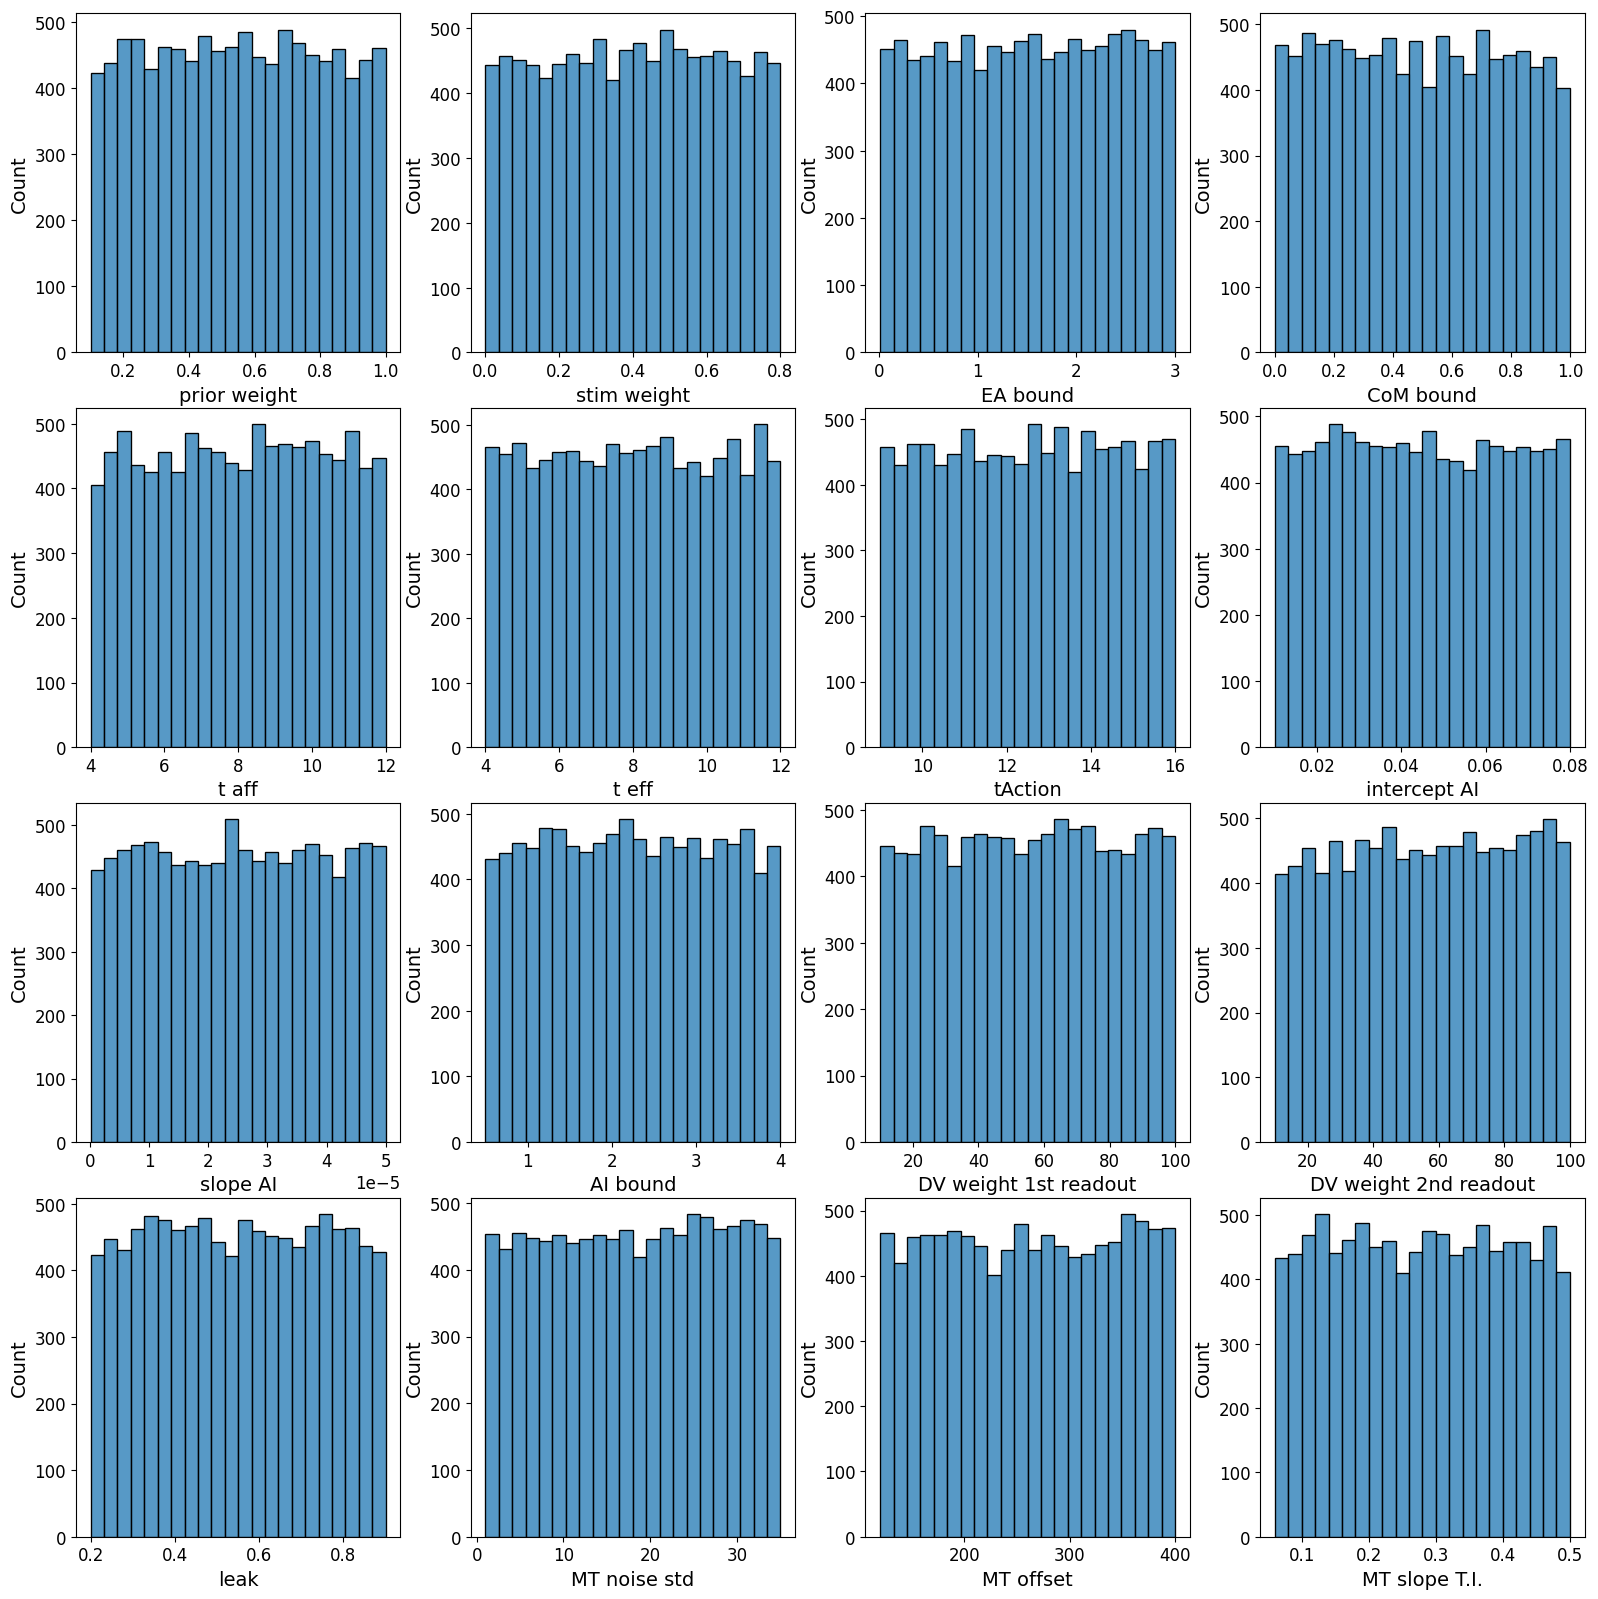

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16,16))
fig.tight_layout()
ax = ax.flatten()
for iax in range(len(ax)):
    sns.histplot(theta_all[:, iax], ax=ax[iax])
    ax[iax].set_xlabel(labels[iax])
plt.show()

Now we proceed to simulate 10000 <b>different trials</b> (one for each different combination of parameters extracted from the prior distro). The function ```simulation``` simulates the model and returns a tensor with three columns: Motor Time, Reaction Time & Choice.

In [8]:
# Prepare data:
coh = np.resize(coh, num_simulations)
zt = np.resize(zt, num_simulations)
trial_index = np.resize(trial_index, num_simulations)
stim = np.resize(stim, (num_simulations, 20))
gt = np.resize(gt, num_simulations)
mt = np.resize(mt, num_simulations)
choice = np.resize(choice, num_simulations)
rt = np.resize(df.sound_len.values, num_simulations)

x_o = torch.column_stack((torch.tensor(mt*1e3),  # MT in ms
                          torch.tensor(rt),  # already in ms
                          torch.tensor(choice)))  # choice is 0, 1
x_o = x_o.to(torch.float32)

In [9]:
# run simulations
x = torch.tensor(())
print('Starting simulation')
for i_t, theta in enumerate(theta_all):  # for each set of parameters and experimental conditions, simulate
    if (i_t+1) % 50000 == 0 and i_t != 0:
        print('Simulation number: ' + str(i_t+1))
    p_w_zt = float(theta[0])
    p_w_stim = float(theta[1])
    p_e_bound = float(theta[2])
    p_com_bound = float(theta[3])*p_e_bound
    p_t_aff = int(np.round(theta[4]))
    p_t_eff = int(np.round(theta[5]))
    p_t_a = int(np.round(theta[6]))
    p_w_a_intercept = float(theta[7])
    p_w_a_slope = -float(theta[8])
    p_a_bound = float(theta[9])
    p_1st_readout = float(theta[10])
    p_2nd_readout = float(theta[11])
    p_leak = float(theta[12])
    p_mt_noise = float(theta[13])
    p_mt_intercept = float(theta[14])
    p_mt_slope = float(theta[15])
    try:
        x_temp = simulation(stim[i_t, :], zt[i_t], coh[i_t],
                            np.array([trial_index[i_t]]), gt[i_t],
                            None, pright,
                            p_w_zt, p_w_stim, p_e_bound, p_com_bound,
                            p_t_aff, p_t_eff, p_t_a, p_w_a_intercept,
                            p_w_a_slope, p_a_bound, p_1st_readout,
                            p_2nd_readout, p_leak, p_mt_noise,
                            p_mt_intercept, p_mt_slope,
                            rms_comparison=False,
                            num_times_tr=num_times_tr, mnle=True)
    except ValueError:  # in case there is an error with the parameter combinations
        x_temp = torch.tensor([[np.nan, np.nan, np.nan]])
    x = torch.cat((x, x_temp))
print('Ended simulation')
x = x.to(torch.float32)


Starting simulation
Ended simulation


We can plot the MT distro conditioning by choice, coh...:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


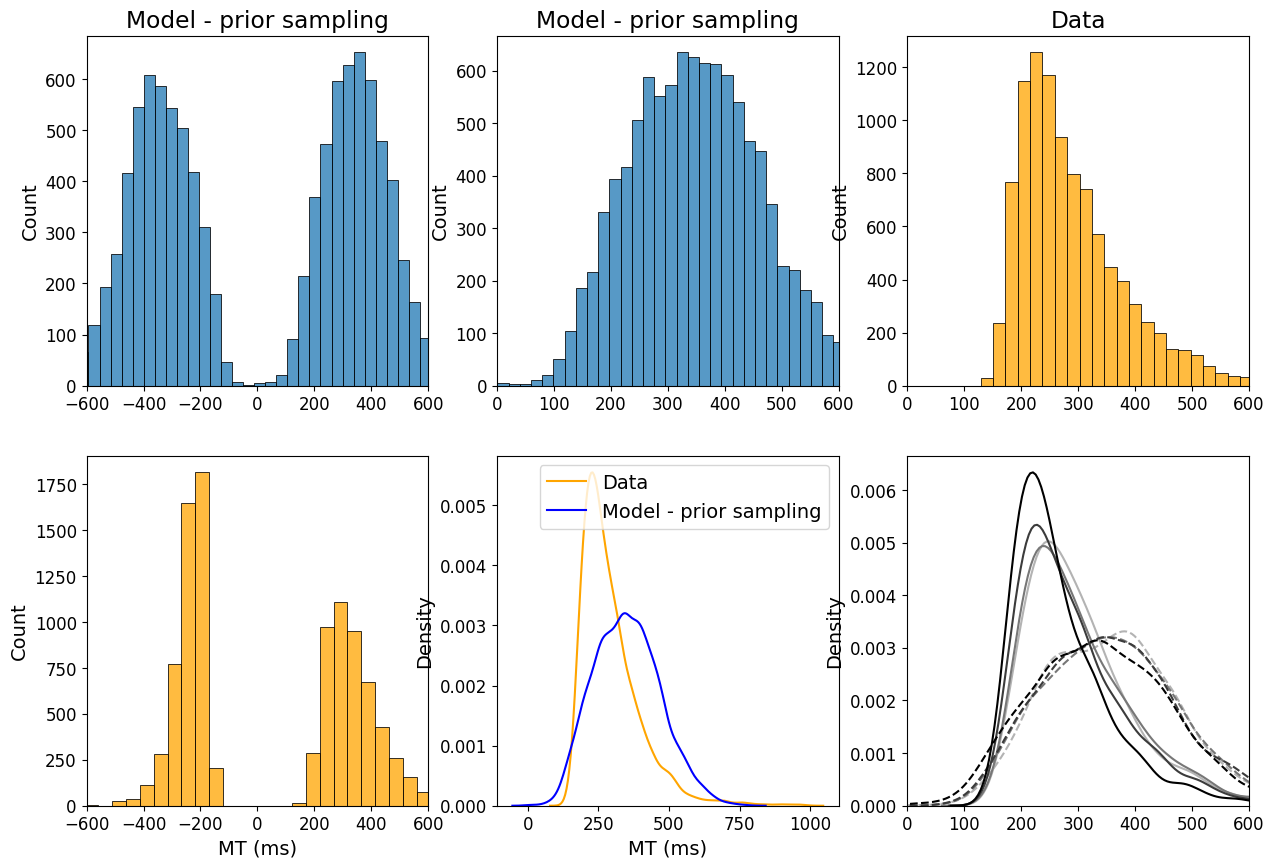

In [10]:
x_syn_1d = x.clone().detach()
x_syn_1d[x_syn_1d[:, 2] < 1, 0] *= -1
mt_sign = np.copy(mt[:num_simulations]*1e3)
mt_sign[choice[:num_simulations] == 0] *= -1
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax = ax.flatten()
sns.histplot(x_syn_1d[:, 0], ax=ax[0], bins=40)
sns.histplot(x[:,0], ax=ax[1], bins=40)
sns.histplot(mt*1e3, color='orange', ax=ax[2], bins=40)
sns.histplot(mt_sign, color='orange', ax=ax[3], bins=40)
sns.kdeplot(mt*1e3, color='orange', ax=ax[4], label='Data')
sns.kdeplot(x[:,0], color='blue', ax=ax[4], label='Model - prior sampling')
ax[4].legend()
ax[1].set_title('Model - prior sampling')
ax[0].set_title('Model - prior sampling')
ax[2].set_title('Data')
ax[3].set_xlabel('MT (ms)')
ax[4].set_xlabel('MT (ms)')
for i in range(2):
    ax[i+1].set_xlim(0, 600)
ax[3].set_xlim(-600, 600)
ax[0].set_xlim(-600, 600)

colormap = pl.cm.gist_gray_r(np.linspace(0.3, 1, 4))
for iev, ev in enumerate([0, 0.25, 0.5, 1]):
    index = np.abs(coh) == ev
    sns.kdeplot(mt[np.abs(coh) == ev]*1e3, color=colormap[iev], ax=ax[5])
    sns.kdeplot(x[np.abs(coh[:len(x)]) == ev, 0], color=colormap[iev], ax=ax[5], linestyle='--')
ax[5].set_xlim(0, 600)
plt.show()

In [11]:
assert x.shape == x_o.shape

Once we have all the simulated data, we can train the network (filtering nans). We transform the parameter vector so that it includes the experimental conditions of stimulus (``coh``), prior (``zt``) and trial index (``trial_index``). To do so, we multiply the prior weight and the stimulus drift by the prior and stimulus, respectively:

``theta_all_inp[:, 0] *= torch.tensor(zt[:num_simulations]).to(torch.float32)``

``theta_all_inp[:, 1] *= torch.tensor(coh[:num_simulations]).to(torch.float32)``

Then, we include the trial index in the corresponding parameters for both the AI and the MT. With that, we get

MT_in = MT_0 + MT_1*trial_index

``theta_all_inp[:, 14] += theta_all_inp[:, 15]*trial_index_tensor``

V_A = vA_0 - vA_1*trial_index    (vA_1 is positive)


``theta_all_inp[:, 7] -= theta_all_inp[:, 8]*trial_index_tensor``


Where we transform 4 parameters into 2. Therefore, we reduce by 2 the length of theta.

In [12]:
nan_mask = torch.sum(torch.isnan(x), axis=1).to(torch.bool)
theta_all_inp = theta_all.clone().detach()
theta_all_inp[:, 0] *= torch.tensor(zt[:num_simulations]).to(torch.float32)
theta_all_inp[:, 1] *= torch.tensor(coh[:num_simulations]).to(torch.float32)
trial_index_tensor = torch.tensor(trial_index[:num_simulations].astype(float)).to(torch.float32)
theta_all_inp = theta_all_inp.to(torch.float32)
# transform parameters related to trial index. 14 params instead of 16
# MT_in = MT_0 + MT_1*trial_index
theta_all_inp[:, 14] += theta_all_inp[:, 15]*trial_index_tensor
# V_A = vA_0 - vA_1*trial_index
theta_all_inp[:, 7] -= theta_all_inp[:, 8]*trial_index_tensor
theta_all_inp = torch.column_stack((theta_all_inp[:, :8],
                                    theta_all_inp[:, 9:-1]))
print(f"We have reduced a vector of length {theta_all.shape[1]} to one of length {theta_all_inp.shape[1]}.")

We have reduced a vector of length 16 to one of length 14.


Now we can start the training. To do so, we first define the trainer ``trainer = MNLE()``, and then append the simulations ``x`` to it using ``append_simulations(theta, x)``. Finally, we call the function ``train()``.

In [13]:
time_start = time.time()
trainer = MNLE(prior=prior)
estimator = trainer.append_simulations(theta_all_inp[~nan_mask, :],
                                       x[~nan_mask, :]).train(show_train_summary=True)
print('For a batch of ' + str(num_simulations) + ' simulations, it took ' + str(int(time.time() - time_start)/60) + ' mins')

 Neural network successfully converged after 54 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 54
        Best validation performance: -10.8046
        -------------------------
        
For a batch of 10000 simulations, it took 5.566666666666666 mins


Now we will use ```PyBADS``` for MLE. First, we have to define the negative log-likelihood function, which will be a piecewise function depending on $RT$. If the $RT$ is positive, then the likelihood will be the one from MNLE, otherwise, it will be the pdf of the first passage time of the Action Initiation process (inverse Gaussian).


$NLLH(n) =
\begin{cases}
                               NLLH_{MNLE}(choice_i, RT_i, MT_i| \theta ) & \text{if $RT_i > 0$} \\
                               NLLH_{AI}(RT_i | \theta ) & \text{if $RT_i < 0$}
\end{cases}$


where $NNLH_{AI} = \sum_i^N log(p(RT_i | \theta))$, and $p(RT_i | \theta)$ is the inverse Gaussian or Wald distribution.

In [14]:
def prob_rt_fb_action(t, v_a, t_a, bound_a):  #inverse Gaussian
    # returns p(RT | theta) for RT < 0
    return (bound_a / np.sqrt(2*np.pi*(t - t_a)**3)) *\
        np.exp(- ((v_a**2)*((t-t_a) - bound_a/v_a)**2)/(2*(t-t_a)))


def get_log_likelihood_fb_psiam(rt_fb, theta_fb, eps, dt=5e-3):
    # returns - \sum LLH ( RT | theta ) for RT < 0
    v_a = -theta_fb[:, 8]*theta_fb[:, -1] + theta_fb[:, 7]  # v_a = b_o - b_1*t_index
    v_a = v_a.detach().numpy()/dt
    bound_a = theta_fb[:, 9].detach().numpy()
    t_a = dt*(theta_fb[:, 6] + theta_fb[:, 5]).detach().numpy()
    t = rt_fb*1e-3
    prob = prob_rt_fb_action(t=t, v_a=v_a, t_a=t_a, bound_a=bound_a)  # compute prob(RT | theta)
    prob[np.isnan(prob)] = 0
    # apply contaminants, log and sum to return - \sum LLH ( RT | theta )
    return -np.nansum(np.log(prob*(1-eps) + eps*CTE_FB))


def fun_theta(theta, data, estimator, n_trials, eps=1e-3):  # negative log likelihood
    # returns - \sum LLH ( choice, RT, MT | theta ) for all RT
    zt = data[:, 0]
    coh = data[:, 1]
    trial_index = data[:, 2]
    x_o = data[:, 3::]  # contains MT, RT, choice of data
    theta = torch.reshape(torch.tensor(theta),
                          (1, len(theta))).to(torch.float32)
    theta = theta.repeat(n_trials, 1)
    theta[:, 0] *= torch.tensor(zt[:n_trials])
    theta[:, 1] *= torch.tensor(coh[:n_trials])
    t_i = torch.tensor(
        trial_index[:n_trials]).to(torch.float32)
    theta = torch.column_stack((theta, t_i))
    x_o = x_o[:n_trials].detach().numpy()
    # trials with RT >= 0
    # we have to pass the same parameters as for the training (14 columns)
    # first, we filter the data and theta to get the indices where RT > 0, i.e. the rows where there are no NaNs in x_o
    x_o_no_fb = torch.tensor(
        x_o[np.isnan(x_o).sum(axis=1) == 0, :]).to(torch.float32)
    theta_no_fb = torch.tensor(
        theta.detach().numpy()[np.isnan(x_o).sum(axis=1) == 0, :]).to(torch.float32)
    # transform parameters related to trial index. 14 params instead of 16
    # MT_in = MT_0 + MT_1*trial_index
    theta_no_fb[:, 14] += theta_no_fb[:, 15]*theta_no_fb[:, -1]
    # V_A = vA_0 - vA_1*trial_index
    theta_no_fb[:, 7] -= theta_no_fb[:, 8]*theta_no_fb[:, -1]
    theta_no_fb = torch.column_stack((theta_no_fb[:, :8],
                                      theta_no_fb[:, 9:15]))
    log_liks = estimator.log_prob(x_o_no_fb, context=theta_no_fb).detach().numpy()  #take log prob from MNLE
    log_liks = np.exp(log_liks)*(1-eps) + eps*CTE  # add contaminants
    log_liks = np.log(log_liks)  # take log prob
    log_liks_no_fb = -np.nansum(log_liks)  # sum over all data points to get -LLH (data | theta) for RT > 0
    # Now trials with RT < 0 (fixation breaks, FB)
    # we use the analytical computation of p(RT | theta) for FB
    x_o_with_fb = x_o[np.isnan(x_o).sum(axis=1) > 0, :]
    theta_fb = theta[np.isnan(x_o).sum(axis=1) > 0, :]
    log_liks_fb = get_log_likelihood_fb_psiam(rt_fb=x_o_with_fb[:, 1],
                                              theta_fb=theta_fb, eps=eps) # -LLH (data | theta) for RT < 0
    # returns -LLH (data (RT < 0) | theta) + -LLH (data (RT > 0) | theta) 
    return log_liks_fb + log_liks_no_fb


Now we define the hard ``ub, lb`` and plausible upper/lower bounds ``pub, plb``. Then we prepare ``data`` with fixation breaks, so that ``data`` is (MT_i, RT_i, choice_i) if RT_i > 0 ms, and (NaN, RT_i, NaN) if RT_i < 0 ms. Finally we define the initial point ``x0`` to be centered between the lower and upper plausible bounds, i.e. ``x0 = (pub + plb)/2``.

In [15]:
# x0 = prior.sample((1, ))  #random x0
lb = np.array([np.float64(prior.dists[i].low) for i in range(len(prior.dists))])
ub = np.array([np.float64(prior.dists[i].high) for i in range(len(prior.dists))])
plb = lb + (-lb+ub)/10
pub = ub - (-lb+ub)/10
data = prepare_fb_data(df=df)  # prepares data = (MT, RT, choice) with fixation breaks
# data is (MT_i, RT_i, choice_i) if RT_i > 0 ms, and (NaN, RT_i, NaN) if RT_i < 0 ms
x0 = (pub + plb)/2  # centered x0

Preparing FB data


Finally, we define ``fun_target``, which is the function that returns the sum of negative likelihood given some parameters $\theta$. This will be the function which ``BADS`` will optimize. To do so, we first define ``bads`` with the target function ``fun_target``, the initial point ``x0``, and the hard and plausible upper/lower bounds ``ub, lb, pub, plb``. To optimize, we have to call ``bads.optimize()``.

In [16]:
fun_target = lambda x: fun_theta(x, data, estimator, num_simulations)  # f(data|theta)
bads = BADS(fun_target, x0, lb, ub, plb, pub)
optimize_result = bads.optimize()

Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2          154612               1                                 Uncertainty test
     0          34          122786               1         Initial mesh            Initial points
     0          35          122242               1       Successful poll           Train
     1          37          120608               1     Successful search (ES-ell)        
     1          46          120467               1     Successful search (ES-ell)        
     1          49          120445               1     Successful search (ES-ell)        
     1          51          120264               1     Successful search (ES-ell)        
     1          53          120210               1     Successful search (ES-ell)        
     1          54          119757               1     Successful search (ES-ell)        
     1          56  

     2         390          115515             0.5     Incremental search (ES-ell)        
     2         414          115515            0.25         Refine grid             Train
     3         429          115515            0.25     Incremental search (ES-ell)        
     3         430          115515            0.25     Incremental search (ES-ell)        
     3         457          115515           0.125         Refine grid             
     4         464          115515           0.125     Incremental search (ES-ell)        
     4         472          115515           0.125     Incremental search (ES-ell)        
     4         502          115515          0.0625         Refine grid             
     5         507          115515          0.0625     Incremental search (ES-ell)        
     5         513          115515          0.0625     Incremental search (ES-ell)        
     5         547          115515         0.03125         Refine grid             Train
     6         55

The best parameters for this rat and 10000 simulations (fitted for choice, MT and RT) are:

In [17]:
optimize_result.x

array([1.00000001e-01, 5.49674269e-01, 1.41229932e+00, 3.23016364e-01,
       8.20891418e+00, 1.11802277e+01, 1.59999973e+01, 5.63792712e-02,
       1.39941984e-05, 2.36900406e+00, 1.83592224e+01, 1.00000000e+02,
       2.83331413e-01, 3.18197502e+01, 2.09096832e+02, 1.09663817e-01])

In [18]:
# save parameters
np.save(SV_FOLDER + 'params_mnle_bads.npy', optimize_result.x)

Now we can simulate using the fitted parameters

In [19]:
# run simulations
x = torch.tensor(())
print('Starting simulation')
theta_fit = optimize_result.x
for i_t, theta in enumerate(theta_all):
    theta = theta_fit
    if (i_t+1) % 50000 == 0 and i_t != 0:
        print('Simulation number: ' + str(i_t+1))
    p_w_zt = float(theta[0])
    p_w_stim = float(theta[1])
    p_e_bound = float(theta[2])
    p_com_bound = float(theta[3])*p_e_bound
    p_t_aff = int(np.round(theta[4]))
    p_t_eff = int(np.round(theta[5]))
    p_t_a = int(np.round(theta[6]))
    p_w_a_intercept = float(theta[7])
    p_w_a_slope = -float(theta[8])
    p_a_bound = float(theta[9])
    p_1st_readout = float(theta[10])
    p_2nd_readout = float(theta[11])
    p_leak = float(theta[12])
    p_mt_noise = float(theta[13])
    p_mt_intercept = float(theta[14])
    p_mt_slope = float(theta[15])
    try:
        x_temp = simulation(stim[i_t, :], zt[i_t], coh[i_t],
                            np.array([trial_index[i_t]]), gt[i_t],
                            None, pright,
                            p_w_zt, p_w_stim, p_e_bound, p_com_bound,
                            p_t_aff, p_t_eff, p_t_a, p_w_a_intercept,
                            p_w_a_slope, p_a_bound, p_1st_readout,
                            p_2nd_readout, p_leak, p_mt_noise,
                            p_mt_intercept, p_mt_slope,
                            rms_comparison=False,
                            num_times_tr=num_times_tr, mnle=True)
    except ValueError:
        x_temp = torch.tensor([[np.nan, np.nan, np.nan]])
    x = torch.cat((x, x_temp))
print('Ended simulation')
x = x.to(torch.float32)
x[:, 1] = x[:, 1] - 300  # we subtract the fixation time

Starting simulation


Now we can take a look at the fits of the model. First for MT:

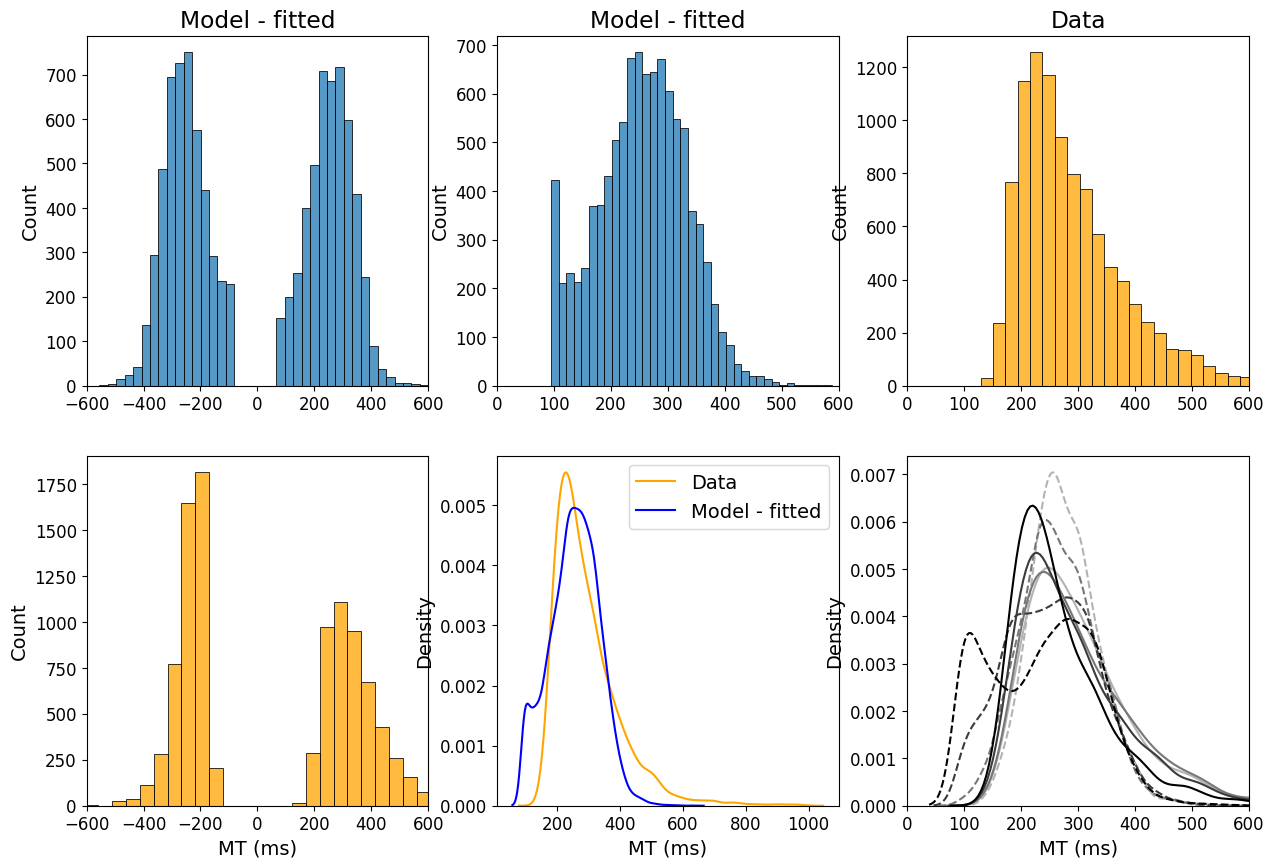

In [20]:
x_syn_1d = x.clone().detach()
x_syn_1d[x_syn_1d[:, 2] < 1, 0] *= -1
mt_sign = np.copy(mt[:num_simulations]*1e3)
mt_sign[choice[:num_simulations] == 0] *= -1
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax = ax.flatten()
sns.histplot(x_syn_1d[:, 0], ax=ax[0], bins=40)
sns.histplot(x[:,0], ax=ax[1], bins=40)
sns.histplot(mt*1e3, color='orange', ax=ax[2], bins=40)
sns.histplot(mt_sign, color='orange', ax=ax[3], bins=40)
sns.kdeplot(mt*1e3, color='orange', ax=ax[4], label='Data')
sns.kdeplot(x[:,0], color='blue', ax=ax[4], label='Model - fitted')
ax[4].legend()
ax[1].set_title('Model - fitted')
ax[0].set_title('Model - fitted')
ax[2].set_title('Data')
ax[3].set_xlabel('MT (ms)')
ax[4].set_xlabel('MT (ms)')
ax[5].set_xlabel('MT (ms)')
for i in range(2):
    ax[i+1].set_xlim(0, 600)
ax[3].set_xlim(-600, 600)
ax[0].set_xlim(-600, 600)

colormap = pl.cm.gist_gray_r(np.linspace(0.3, 1, 4))
for iev, ev in enumerate([0, 0.25, 0.5, 1]):
    index = np.abs(coh) == ev
    sns.kdeplot(mt[np.abs(coh) == ev]*1e3, color=colormap[iev], ax=ax[5])
    sns.kdeplot(x[np.abs(coh[:len(x)]) == ev, 0], color=colormap[iev], ax=ax[5], linestyle='--')
ax[5].set_xlim(0, 600)
plt.show()
fig.tight_layout()

Now for RT:

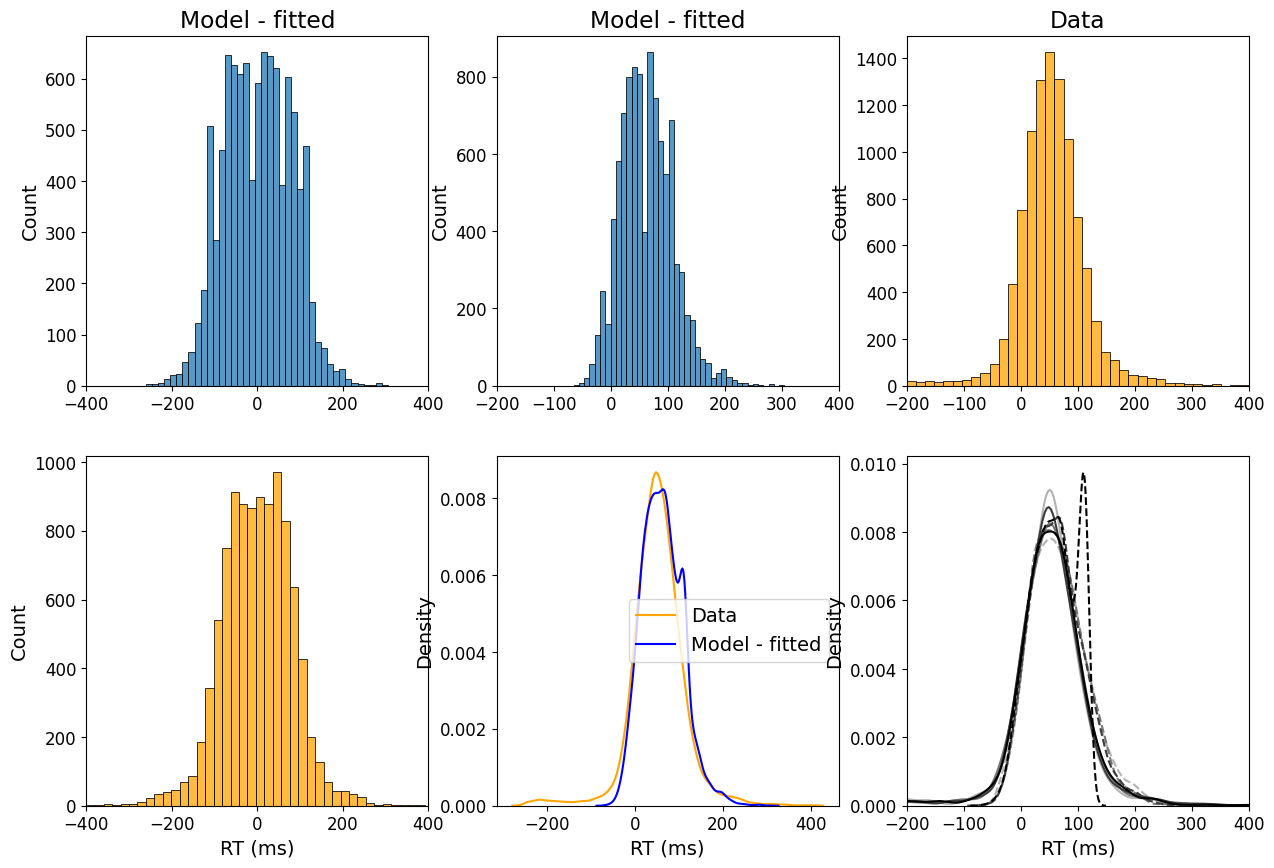

In [21]:
rt = data[:, 4] - 300  # we subtract the fixation time
rt = rt[np.random.choice(np.arange(len(rt)), num_simulations)]
x_syn_1d = x.clone().detach()
x_syn_1d[x_syn_1d[:, 2] < 1, 1] *= -1
rt_sign = np.copy(rt[:num_simulations])
rt_sign[choice[:num_simulations] == 0] *= -1
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax = ax.flatten()
sns.histplot(x_syn_1d[:, 1], ax=ax[0], bins=40)
sns.histplot(x[:,1], ax=ax[1], bins=40)
sns.histplot(rt, color='orange', ax=ax[2], bins=40)
sns.histplot(rt_sign, color='orange', ax=ax[3], bins=40)
sns.kdeplot(rt, color='orange', ax=ax[4], label='Data')
sns.kdeplot(x[:,1], color='blue', ax=ax[4], label='Model - fitted')
ax[4].legend()
ax[1].set_title('Model - fitted')
ax[0].set_title('Model - fitted')
ax[2].set_title('Data')
ax[3].set_xlabel('RT (ms)')
ax[4].set_xlabel('RT (ms)')
ax[5].set_xlabel('RT (ms)')
for i in range(2):
    ax[i+1].set_xlim(-200, 400)
ax[3].set_xlim(-400, 400)
ax[0].set_xlim(-400, 400)

colormap = pl.cm.gist_gray_r(np.linspace(0.3, 1, 4))
for iev, ev in enumerate([0, 0.25, 0.5, 1]):
    index = np.abs(coh) == ev
    sns.kdeplot(rt[np.abs(coh) == ev], color=colormap[iev], ax=ax[5])
    sns.kdeplot(x[np.abs(coh[:len(x)]) == ev, 1], color=colormap[iev], ax=ax[5], linestyle='--')
ax[5].set_xlim(-200, 400)
plt.show()
fig.tight_layout()

We can see that the fits improved much compared to the prior estimates.

Now we can build the posterior distributon

In [22]:
# Markov chain Monte-Carlo (MCMC) to get posterior distros
num_samples = 10000

mcmc_parameters = dict(num_chains=4, thin=10,
                       warmup_steps=num_samples//4,
                       init_strategy="proposal",
                       num_workers=1,)
mnle_posterior = trainer.build_posterior(prior=prior,
                                         mcmc_method="hmc",
                                         mcmc_parameters=mcmc_parameters)
# we actually cannot since prior shape is different than the actual theta shape

Now we extract samples for the posterior using MCMC, to get a distro of each parameter.

In [23]:
# at this point, we should re-simulate the model with all trials
# mnle_samples = mnle_posterior.sample((num_samples,), x=x_o,
#                                      show_progress_bars=True)

Or we can use ```arviz```

In [24]:
# import arviz as az
# # get arviz InferenceData object from posterior
# inference_data = mnle_posterior.get_arviz_inference_data()
# print(inference_data.posterior)
